#### Plan for synthetic data 
1. Create synthetic datasets
2. Run synthetic unbiased fair synthetic dataset
3. add in error + bias into Y-train, make it rely on S
4. run pipeline on new data and try to get it to meet the same baseline as the original dataset for demographic parity + accuracy.

#### Additional work 
hypertune for lambda so that accuracy and demographic parity are well balanced.

In [1]:
# !pip install fairlearn

import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import random
import datetime

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, 
    MaxPooling2D, BatchNormalization, Dropout, Concatenate
)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)

from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2025-02-15 15:24:08.701595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 15:24:08.701650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 15:24:08.703209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 15:24:08.712951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -------------------------------
# Custom Gradient Reversal Layer
# -------------------------------
@tf.custom_gradient
def grad_reverse(x, lambda_):
    def grad(dy):
        return -lambda_ * dy, None # reverses direction of gradient 
    return x, grad

# custom Keras layer
"""
Layer is used to ensure that the feature representation are independent of a sensitive attribute
- feature extract learns normally in the forward pass
- reversing gradients of classifier that tries to predict the sensitive attribute during backpropagation -- stops feature extractor from encoding sensitive information
"""
class GradientReversalLayer(tf.keras.layers.Layer): 
    def __init__(self, lambda_=1.0, **kwargs):
        super(GradientReversalLayer, self).__init__(**kwargs)
        self.lambda_ = lambda_ # strength of gradient reversal
    def call(self, x):
        return grad_reverse(x, self.lambda_)

# -------------------------------
# Data Loading and Preprocessing
# -------------------------------
def set_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    tf.random.set_seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

In [3]:
# -------------------------------
# Adversarial Debiasing Model
# -------------------------------
def build_adversarial_model(input_dim, lambda_adv=1.0):
    """
    Build an adversarial debiasing model that learns pseudo‑labels Y' from X.

    Architecture:
      - Main branch (encoder): from X, several dense layers produce a latent pseudo‑label pseudo_Y (via sigmoid).
      - Adversary branch: pseudo_Y is passed through a Gradient Reversal Layer and then dense layers predict S.
      - Decoder branch: concatenates pseudo_Y and the one-hot sensitive attribute S to predict the observed label Y.

    Losses:
      - For the main branch, binary crossentropy between observed Y and pseudo_Y (and Y_pred).
      - For the adversary branch, categorical crossentropy to predict S.

    Returns a compiled Keras model that takes inputs X and S (one-hot encoded) and outputs:
      [pseudo_Y, S_pred, Y_pred].
    """
    X_input = tf.keras.Input(shape=(input_dim,), name="X")
    S_input = tf.keras.Input(shape=(2,), name="S")  # one-hot encoded S

    # Main branch: Encoder for pseudo-label.
    """
    """
    h = Dense(64, activation='relu')(X_input)
    h = BatchNormalization()(h)
    h = Dense(32, activation='relu')(h)
    h = BatchNormalization()(h)
    pseudo_Y = Dense(1, activation='sigmoid', name="pseudo_Y")(h) ## outputs  probability value for pseudo_Y between 0,1

    # Adversary branch: from pseudo_Y, with GRL.
    """
    This is to prevent psuedo_Y from containing information about S
    - adversary will try to predict S from pseudo_Y (fair label)...if it can accurately predict S, then Y' still encodes information about S (don't want this) 
    - use the gradient reversal layer to prevent this from happening
    """
    grl = GradientReversalLayer(lambda_=lambda_adv)(pseudo_Y)
    a = Dense(32, activation='relu')(grl)
    a = BatchNormalization()(a)
    S_pred = Dense(2, activation='softmax', name="S_pred")(a)

    # Decoder branch: combine pseudo_Y and S to predict observed Y.
    """
    Y depepends on both Y' and S 
    -- predict the final observed label Y using both psuedo_Y and S
    -- Y may still depend on S, that is why it's being used here 
    -- decoder ensures Y_final is accurate, while psuedo_Y is not directly influenced by S 
    -- psuedo_Y removes unfair dependencies on S...however S might still contain legit info needed to predict Y accurately 
    -- IMPORTANT - THIS STEP ALLOWS FAIR DEPENDENCIES WHILE ELIMINATING UNFAIR ONES
    -- structure how S influences Y, without letting hidden biases leak through 
    """
    concat = Concatenate()([pseudo_Y, S_input])
    d = Dense(16, activation='relu')(concat)
    d = BatchNormalization()(d)
    Y_pred = Dense(1, activation='sigmoid', name="Y_pred")(d)

    model = tf.keras.Model(inputs=[X_input, S_input],
                           outputs=[pseudo_Y, S_pred, Y_pred])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss={"pseudo_Y": "binary_crossentropy",
                        "S_pred": "categorical_crossentropy",
                        "Y_pred": "binary_crossentropy"},
                  loss_weights={"pseudo_Y": 1.0, "S_pred": lambda_adv, "Y_pred": 1.0},
                  metrics={"pseudo_Y": "accuracy",
                           "S_pred": "accuracy",
                           "Y_pred": "accuracy"}) # Y_pred is the best estimate of Y accounting for fair dependencies 
    return model

In [4]:
# -------------------------------
# Manual Fairness Metrics
# -------------------------------
def compute_fairness_metrics_manual(y_true, y_pred, sensitive_features):
    """
    Compute fairness metrics manually.
    y_true: binary ground-truth labels (1-D numpy array).
    y_pred: continuous scores (will be thresholded at 0.5).
    sensitive_features: 1-D numpy array (0 or 1).

    Returns a dictionary with:
      - Demographic parity difference (absolute difference in positive rates).
      - Equalized odds difference (average difference in TPR and FPR).
      - Selection rates per group.
      - Group-wise accuracy.
    """
    y_pred_bin = (y_pred > 0.5).astype(int) # y_pred is continuous value, so converting it to binary 
    groups = np.unique(sensitive_features)

    # Demographic parity 
    """
    All groups (from sensitive feature) should receive positive predictions at the same rate
    P(Y_hat = 1|S=0) = P(Y_hat=1|S=1)
    """

    # For each group in the sensitive feature, find the demographic parity and compute the difference (based on the formula in above comment)
    pos_rates = {}
    for g in groups: 
        pos_rates[g] = np.mean(y_pred_bin[sensitive_features == g])
    dp_diff = abs(pos_rates[0] - pos_rates[1]) ## this line assumes that there are only 2 groups, 0 and 1 -- if there are more than 2 groups, this would need to be changed
    ## in all the examples used, there were only 2 groups -- need to double check this when working on new data
    
    # dp_diff > 0, then demographic parity isn't fair 

    # Equalized odds
    """
    Ensuring the different groups in the sensitive feature similar TPR and FPR rates -- this is so that the model isn't discriminating in error types
    """
    metrics = {}
    for g in groups:
        mask = (sensitive_features == g)
        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin[mask]
        tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / (np.sum(y_true_g == 1) + 1e-8) # True Positive Rate
        fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / (np.sum(y_true_g == 0) + 1e-8) # False Positive Rate
        metrics[g] = (tpr, fpr)
    eo_diff = (abs(metrics[0][0] - metrics[1][0]) + abs(metrics[0][1] - metrics[1][1])) # taking average of two error types

    # Selection rate per group.
    """
    proportion of samples predicted as positive for each group -- a a group has a higher selection rate, the model may favor that group unfairly
    """
    sel_rate = {}
    for g in groups:
        sel_rate[g] = pos_rates[g]

    # Group-wise accuracy.
    """
    for each group in the sensitive feature, compute the accuracy of the model (to ensure that it's perfoming consistently across groups)
    """
    group_acc = {}
    for g in groups:
        mask = (sensitive_features == g)
        group_acc[g] = accuracy_score(y_true[mask], y_pred_bin[mask])

    return {
        "demographic_parity_difference": dp_diff,
        "equalized_odds_difference": eo_diff,
        "selection_rate": sel_rate,
        "group_accuracy": group_acc
    }

In [5]:
# -------------------------------
# Plotting Function
# -------------------------------
def plot_comparison(metrics_baseline, metrics_fair):
    """
    parameters are dictionaries with the stored values of the evaluation metrics
    """
    models = ['Baseline', 'Fair']
    aucs = [metrics_baseline['auc'], metrics_fair['auc']]
    accs = [metrics_baseline['accuracy'], metrics_fair['accuracy']]
    dp_diff = [metrics_baseline["demographic_parity_difference"], metrics_fair["demographic_parity_difference"]]
    eo_diff = [metrics_baseline["equalized_odds_difference"], metrics_fair["equalized_odds_difference"]]

    # creating a 2x3 gird of bar chars comparing baseline model and fair model across: AUC, accuracy, demographic parity diff, equalized odd difference
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    ## measures how well the model seperates postiive and negative classes, higher AUC = better model performance
    # if fair model has a lower AUC than the baseline, can indicate a fairness-performance tradeoff (meaning less well seperation for more fair results)
    axs[0,0].bar(models, aucs, color=['blue', 'green'])
    axs[0,0].set_title('AUC')
    axs[0,0].set_ylim([0, 1])

    ## correct pred/total pred
    ## fairness may lower accuracy 
    axs[0,1].bar(models, accs, color=['blue', 'green'])
    axs[0,1].set_title('Accuracy')
    axs[0,1].set_ylim([0, 1])

    ## orange = baseline, purple = fairness -LOOK INTO TO SEE HOW TO KNOW WHICH GROUP IS CONTRIBUTING TO HIGHER DP
    # lower values of dp indciate better fairness
    axs[1,0].bar(models, dp_diff, color=['orange', 'purple'])
    axs[1,0].set_title('Demographic Parity Difference')

    ## lower value - better fairness
    ## equalized odds is satisfied if tpr and fpr are equal across the different groups in the sensitive feature
    axs[1,1].bar(models, eo_diff, color=['orange', 'purple'])
    axs[1,1].set_title('Equalized Odds Difference')

    plt.suptitle("Comparison: Baseline (X → Y) vs. Fair (X → Y') Model")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [6]:
def generate_synthetic_data(n_samples=5000, n_features=30, bias_factor=0.3, noise_level=0.1, seed=42):
    np.random.seed(seed)

    # Generate Sensitive Attribute S ~ Binomial(1, 0.5)
    S = np.random.binomial(1, 0.5, size=n_samples)

    # Generate Features X: Some function of S + Multinomial noise
    X = np.random.randn(n_samples, n_features) + 0.5 * S[:, np.newaxis]

    # Generate True Labels Y (linear function of X + noise)
    true_weights = np.random.randn(n_features)
    Y_continuous = X @ true_weights + np.random.normal(0, noise_level, size=n_samples)

    # Convert Y into discrete categories (multi-class setting)
    Y = np.digitize(Y_continuous, bins=np.percentile(Y_continuous, [50]))  # 2 classes (0,1) ## change this later if we want to see 

    X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test = train_test_split(
        X, Y, S, test_size=0.2, random_state=42
    )

    return X_train, X_test, Y_train_obs, Y_test_obs, S_train, S_test 

In [7]:
# def inject_bias(X_train, Y_train, S_train, X_test, Y_test, S_test, bias_factor=0.3, seed=42):
def inject_bias(bias_factor=0.4, seed=42):
    np.random.seed(seed)
    X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data()
    def apply_bias(Y, S):
        flip_mask = np.random.rand(len(Y)) < bias_factor  # Generate a flip mask for this dataset
        Y_biased = Y.copy()
        Y_biased[flip_mask & (S == 1)] = 1  # Favor positive outcomes for S=1
        Y_biased[flip_mask & (S == 0)] = 0  # Favor negative outcomes for S=0
        return Y_biased

    # Create separate biased labels for train and test
    Y_train_biased = apply_bias(Y_train_raw, S_train)
    Y_test_biased = apply_bias(Y_test_raw, S_test)

    return Y_train_biased, Y_test_biased


In [8]:
def run_logistic(X_train, Y_train, X_test, Y_test, S_train, S_test): 
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(X_train, Y_train)
    preds = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(Y_test, preds)
    acc = accuracy_score(Y_test, (preds > 0.5).astype(int))
    fairness = compute_fairness_metrics_manual(Y_test, preds, sensitive_features=S_test)
    
    return auc, acc,fairness


def run_unbiased_logistic(): 
    X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data() ##  Y is binary class, S is binary
    auc, acc, fairness = run_logistic(X_train, Y_train_raw, X_test, Y_test_raw, S_train, S_test)

    dp_diff = fairness["demographic_parity_difference"]
    eo_diff = fairness["equalized_odds_difference"]

    print (f"Baseline: AUC:{auc}, Accuracy:{acc}, Demographic Parity Difference:{dp_diff}, Equalized Odds Difference:{eo_diff}")

run_unbiased_logistic()

Baseline: AUC:0.9996070947462955, Accuracy:0.99, Demographic Parity Difference:0.015438596491228085, Equalized Odds Difference:0.02260242900471713


In [9]:
# -------------------------------
# Main Function: Comparison and Visualization
# -------------------------------
def main_synthetic(lambda_adv=1.0):
    set_seed(42)

    X_train, X_test, Y_train_raw, Y_test_raw, S_train, S_test = generate_synthetic_data() ##  Y is binary class, S is binary
    # Y_train_biased, Y_test_biased = inject_bias(X_train, Y_train_raw, S_train, Y_test_raw, S_train, S_test, bias_factor=0.3, seed=42)
    Y_train_biased, Y_test_biased = inject_bias(bias_factor=0.3, seed=42)

    input_dim = X_train.shape[1]

    # One-hot encode S for adversarial model training.
    S_train_oh = tf.keras.utils.to_categorical(S_train, num_classes=2)
    S_test_oh  = tf.keras.utils.to_categorical(S_test, num_classes=2)

    ### 1. Train adversarial debiasing model (X → Y' with adversary)
    print("\nTraining adversarial model (X → Y' with adversary) ...")
    adv_model = build_adversarial_model(input_dim, lambda_adv=lambda_adv)
    Y_train_raw_exp = Y_train_raw.reshape(-1, 1)
    Y_test_raw_exp  = Y_test_raw.reshape(-1, 1)
    adv_model.fit([X_train, S_train_oh],
                  {"pseudo_Y": Y_train_raw_exp, "S_pred": S_train_oh, "Y_pred": Y_train_raw_exp},
                  epochs=64, batch_size=128, verbose=1)

    # Get predictions 
    pseudo_Y_train, S_pred, Y_pred_train = adv_model.predict([X_train, S_train_oh]) ## do we want psuedo_Y or Y_pred? psuedo_Y is for complete fairness why pred_Y can be a bit more accurate by keep necessary dependencies
    pseudo_Y_test,  S_pred, Y_pred_test = adv_model.predict([X_test, S_test_oh])

    # # THIS IS WITH PSUEDO_Y - Professor's way
    # Y_pred_train_bin = (pseudo_Y_train > 0.5).astype(np.float32)
    # Y_pred_test_bin  = (pseudo_Y_test > 0.5).astype(np.float32)

    # # THIS IS WITH Y_PRED
    Y_pred_train_bin = (Y_pred_train > 0.5).astype(np.float32)
    Y_pred_test_bin  = (Y_pred_test > 0.5).astype(np.float32)

    print("\nPseudo-label statistics (training):")
    for g in np.unique(S_train):
        mask = (S_train == g)
        print(f"Group {g} pseudo-positive rate: {np.mean(Y_pred_train_bin[mask]):.4f}") # average probability of a postive prediction per group -- fairness check to see if both groups receive similar treatment

    ### 2. Train baseline logistic regression model on observed Y (X → Y) -- regular logistic regression for baseline for comparison; does not include any fairness constraints
    print("\nTraining baseline [BIASED] logistic regression classifier (X → Y)...")
    baseline_auc, baseline_acc, baseline_fairness = run_logistic(X_train, Y_train_biased, X_test, Y_test_biased, S_train, S_test)

    ### 3. Train fair logistic regression model on pseudo-labels (X → Y') -- using psuedo_Y from the the adv_model, 
    print("\nTraining fair logistic regression classifier (X → Y') using pseudo-labels...")
    fair_auc, fair_acc, fair_fairness = run_logistic(X_train, Y_pred_train_bin, X_test, Y_pred_test_bin, S_train, S_test)

    # Aggregate metrics for plotting.
    metrics_baseline = {
        "auc": baseline_auc,
        "accuracy": baseline_acc,
        "demographic_parity_difference": baseline_fairness["demographic_parity_difference"],
        "equalized_odds_difference": baseline_fairness["equalized_odds_difference"]
    }
    metrics_fair = {
        "auc": fair_auc,
        "accuracy": fair_acc,
        "demographic_parity_difference": fair_fairness["demographic_parity_difference"],
        "equalized_odds_difference": fair_fairness["equalized_odds_difference"]
    }

    print("\nBaseline Logistic Regression (X → Y) Evaluation:")
    print(f"AUC: {baseline_auc:.4f}, Accuracy: {baseline_acc:.4f}")
    print("Fairness metrics:", baseline_fairness)

    print("\nFair Logistic Regression (X → Y') Evaluation (compared to observed Y):")
    print(f"AUC: {fair_auc:.4f}, Accuracy: {fair_acc:.4f}")
    print("Fairness metrics:", fair_fairness)

    # Plot comparison.
    plot_comparison(metrics_baseline, metrics_fair)

### Application on Datasets

#### Synthetic Datasets


Training adversarial model (X → Y' with adversary) ...
Epoch 1/64
32/32 [==============================] - 2s 9ms/step - loss: 41.7541 - pseudo_Y_loss: 0.9683 - S_pred_loss: 0.7970 - Y_pred_loss: 0.9367 - pseudo_Y_accuracy: 0.4608 - S_pred_accuracy: 0.4827 - Y_pred_accuracy: 0.4980
Epoch 2/64
32/32 [==============================] - 0s 7ms/step - loss: 43.1924 - pseudo_Y_loss: 0.9947 - S_pred_loss: 0.8259 - Y_pred_loss: 0.9015 - pseudo_Y_accuracy: 0.4482 - S_pred_accuracy: 0.4100 - Y_pred_accuracy: 0.4965
Epoch 3/64
32/32 [==============================] - 0s 7ms/step - loss: 43.0594 - pseudo_Y_loss: 1.0173 - S_pred_loss: 0.8234 - Y_pred_loss: 0.8700 - pseudo_Y_accuracy: 0.4512 - S_pred_accuracy: 0.3677 - Y_pred_accuracy: 0.4955
Epoch 4/64
32/32 [==============================] - 0s 6ms/step - loss: 41.8748 - pseudo_Y_loss: 1.0388 - S_pred_loss: 0.7999 - Y_pred_loss: 0.8427 - pseudo_Y_accuracy: 0.4500 - S_pred_accuracy: 0.3248 - Y_pred_accuracy: 0.4877
Epoch 5/64
32/32 [==============

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


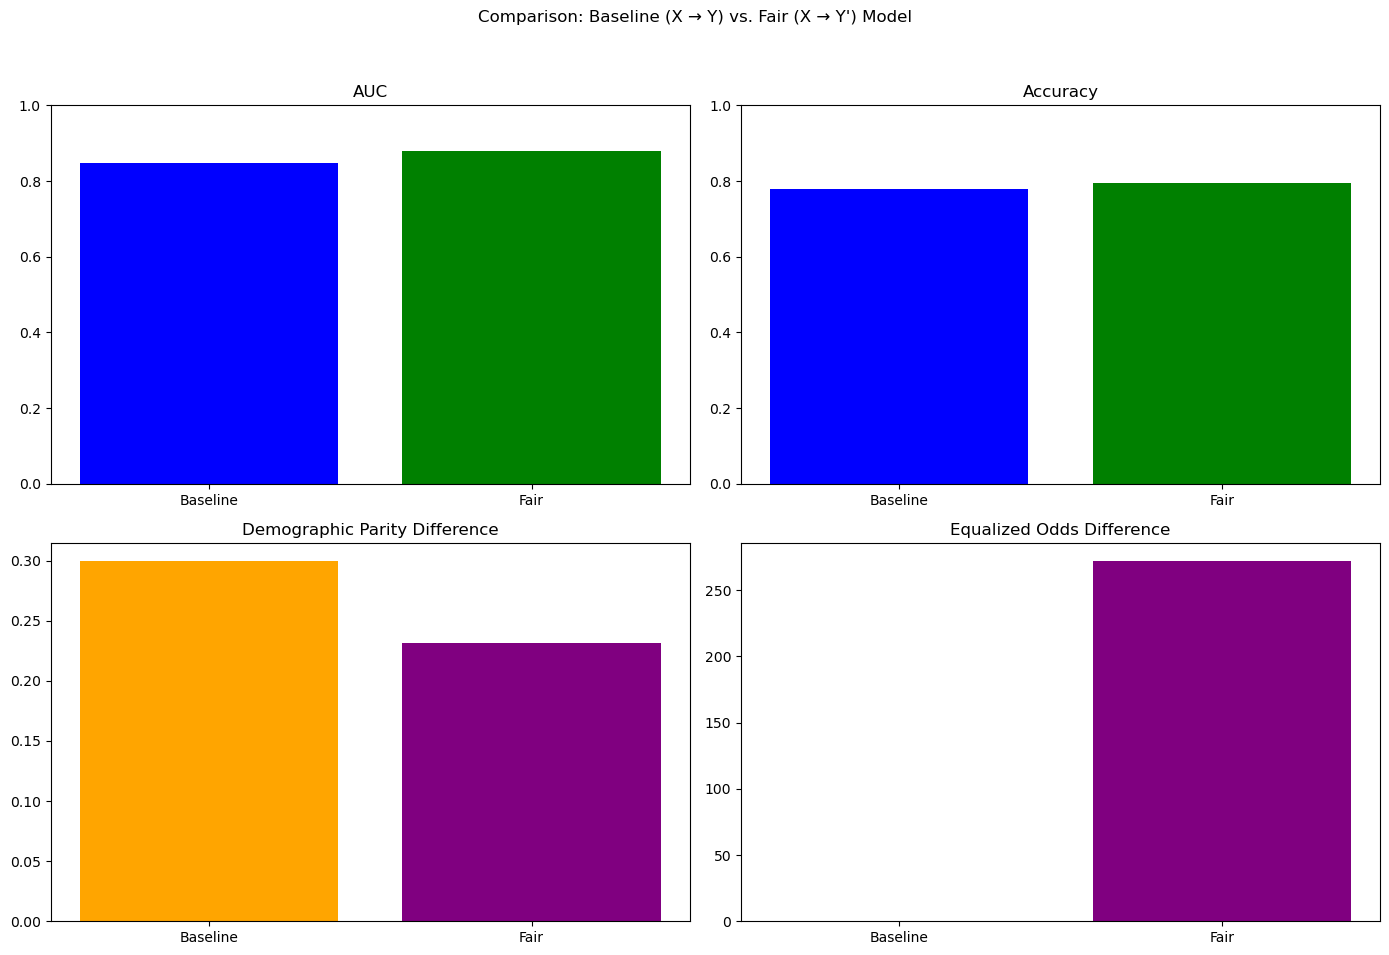

In [10]:
main_synthetic(lambda_adv=50.0)

In [ ]:
### last thing to do -- need to hypertune 
### need to do synthetic dataset for a multiclass